# Some hints

In what follows there are some hints about [substitutions] and useful facts. Some imports as usual:

[substitutions]:http://docs.sympy.org/latest/tutorial/basic_operations.html#substitution

In [1]:
import sympy
from sympy import *
from sympy.abc import x, n, z, t, k

init_printing() # for nice printing, a-la' TeX

## about recurrences: coefficients and operators

to build a recurrence in _math_ style:

In [2]:
a = indexed.IndexedBase('a')
a[n+1]

to fill a recurrence in order to apply the Identity Principle:

In [70]:
kd = KroneckerDelta(n,0)
kd, kd.subs(n,0), kd.subs(n,3)

to generate [permutations], provided by standard Python distribution. SymPy handles [permutations][perm-sympy] as first class objects.

[permutations]:https://docs.python.org/3/library/itertools.html#itertools.permutations
[perm-sympy]:http://docs.sympy.org/dev/modules/utilities/iterables.html#sympy.utilities.iterables.generate_bell

In [96]:
from itertools import permutations
perms=permutations(range(10))
[next(perms) for _ in range(10)]

In [77]:
print(a[n+2].func,a[n+2].args)
checks = Function('\mathcal{C}')
checks_recurrence = Eq(checks(a[n+1]) -4*a[n]+a[n-1], a[n]+a[n]+4)
checks_recurrence

<class 'sympy.tensor.indexed.Indexed'> (a, n + 2)


In [78]:
checks_recurrence.subs(a[n],4)

In [18]:
a[n+1].subs(n+1,n-2)

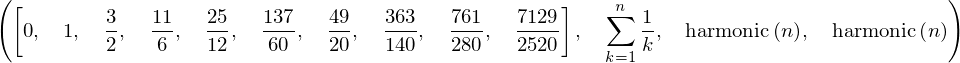

In [40]:
H_as_sum = harmonic(n).rewrite(Sum)
list(map(harmonic, range(10))), H_as_sum, harmonic(n), harmonic(n).doit().expand()

using a `Sum` object inhibits us to rewrite that object as an `harmonic` function object. On the other hand, using a `summation` object does:

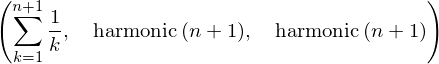

In [38]:
expanded_harmonic_summation = Sum(1/k, (k,1,n+1))
simple_summation = expanded_harmonic_summation.doit()
rewritten_as_harmonic = simple_summation.rewrite(harmonic)
expanded_harmonic_summation, simple_summation, rewritten_as_harmonic

Function `expand_func` allows us to rewrite a composite function application to a more plain one:

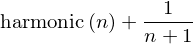

In [30]:
expand_func(harmonic(n+1))

The following is an example of usage of a generator which yield a given term forever, as needed, to build an `Add` object, leaving the summands *unevaluated*...maybe we can use this pattern to unfold a recurrence:

In [69]:
def repeat(x):
    while True:
        yield x
        

Add(*take(repeat(3),10), evaluate=False)

Asymptotically, $n \rightarrow \infty$, harmonic numbers $H_{n}$ behave like logarithm, $\log{n}$, so if we take the [limit] should yield a constant, in particular the [EulerGamma] constant:

[limit]:http://docs.sympy.org/dev/modules/mpmath/calculus/sums_limits.html#limit
[EulerGamma]:http://docs.sympy.org/dev/modules/core.html?highlight=eulergamma#sympy.core.numbers.EulerGamma

In [103]:
should_be_a_EulerGamma_const=(H_as_sum.doit() - log(n)).limit(n,oo)
should_be_a_EulerGamma_const

In [69]:
should_be_a_EulerGamma_const.evalf(), type(should_be_a_EulerGamma_const)

(0.577215664901533, sympy.core.numbers.EulerGamma)

## object language and meta language: different levels for reasoning

We can model operator $\mathcal{G}$ as a first-class _Python_ object, this way allows us to send messages to it, perhaps it should extend class `Function` to be in SymPy hierarchy. If it doesn't, all methods (such as `differentiate`) have to be coded from scratch:

In [100]:
class G():
    def __init__(self, seq): ...
        
G(n*IndexedBase('a')[n]).differentiate()

An alternative should be to define operator $\mathcal{G}$ in the _meta-language_, in order to define rewriting rules to be applied in order to get new terms:

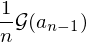

In [42]:
G = Function('\mathcal{G}');
my_term=G(a[n])

def derivative_rule(G_n_an):
    # take apart G_n_an term
    return G(a[n-1])/n

derivative_rule(my_term)

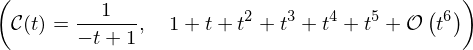

In [121]:
mygf=Eq(Function('\mathcal{C}')(t), 1/(1-t))
mygf, mygf.rhs.series(t)

## matching

It is interesting to look at [matching] capabilities. The following example is kept directly from SymPy docs:

[matching]:http://docs.sympy.org/dev/modules/core.html#sympy.core.basic.Basic.match

In [10]:
>>> from sympy import Wild
>>> from sympy.abc import x, y

>>> p = Wild("p")
>>> q = Wild("q")
>>> r = Wild("r")

>>> e = (x+y)**(x+y)
>>> e.match(p**p)

In [16]:
>>> e.match(p**q)

In [6]:
>>> e = (2*x)**2
>>> e.match(p*q**r)

In [7]:
>>> (p*q**r).xreplace(e.match(p*q**r))

On the other hand the keyword `old` plays well for "computational" patterns. Quoted from official docs:

> The old flag will give the old-style pattern matching where expressions and patterns are essentially solved to give the match. Both of the following give None unless old=True:

In [13]:
>>> (x - 2).match(p - x, old=True)

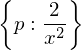

In [17]:
>>> (2/x).match(p*x, old=True)

### applying it to operator $\mathcal{G}$

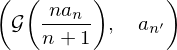

In [43]:
mult_term = Wild("a_{n}'")

term_to_handle = G(a[n]*n/(n+1))
term_to_handle, mult_term

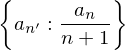

In [44]:
term_to_handle.match(G(n*mult_term))

In [45]:
coeff_term = Wild('a')
index_term = Wild('n')

G(a[n+1]).match(G(coeff_term))

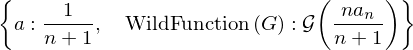

In [61]:
fw = WildFunction('G')

(term_to_handle/(n+1)).match(coeff_term*fw)

Passing `exclude` keyword to `Wild` constructor, allows us to use the matcher object to avoid terms such that contain symbols in the exclude list:

In [83]:
c = Wild('c', exclude=[1,n,a])
c_ = Wild("c'", exclude=[1])
fw_ = WildFunction('G')
G(4*n + 2*(n+1)).match(G(c*n + c_*coeff_term), old=True)

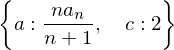

In [85]:
(2*term_to_handle.args[0]).match(c*coeff_term) # excluding `n` makes `c` do match with `2`

In [84]:
(2*a[k]).match(c*coeff_term) # excluding `a` makes `c` do match with `2` again